# Klasifikasi Opini Pengguna Media Sosial Twitter Terhadap Program Kampus Merdeka Dengan Metode Naive Bayes

Dataset yang digunakan dalam analisis ini merupakan data postingan yang berisi tentang program kampus merdeka dengan 2 label (Mendukung & Tidak Mendukung) yang telah di simpan dalam format csv.


# 1. Install & Import Library & Dependencies

In [1]:
# pip install imblearn

In [2]:
# pip install sastrawi

In [3]:
import nltk
import matplotlib.pyplot as plt
import random
import pandas as pd
import numpy as np
import re
import itertools
import string

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
nltk.download('punkt')
nltk.download('stopwords')

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

from datetime import datetime
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.naive_bayes import MultinomialNB
from wordcloud import WordCloud

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 2. Import data tweet Program Kampus Merdeka

In [4]:
df_tweets = pd.read_excel('dataset/dataset.xlsx')
df_tweets.isna().sum()

id       0
Tweet    0
Label    0
dtype: int64

In [5]:
df_tweets

,id,Tweet,Label
0,1,@alahsokap ya kan gua bilang tergantung kampus...,Mendukung
1,2,@fraijours @PeachPluffy Kak saya juga mengikut...,Mendukung
2,3,"@miegacoans @convomfs 3. Kalau masih kupu"" jug...",Mendukung
3,4,@uknowrav Diantara sekian banyak program kampu...,Mendukung
4,5,tp ada saat dimana gua bersyukur banget dan be...,Mendukung
...,...,...,...
852,853,@alandakariza Indonesian International Student...,Mendukung
853,854,Mendikbudristek: Mahasiswa Didorong Ikut Progr...,Mendukung
854,855,Maxy Academy Resmi Jadi Official Partner Kampu...,Mendukung
855,856,Beberapa di antaranya adalah program Kampus Me...,Mendukung


# 3. Delete duplicate & unused column 

In [6]:
df_tweets.drop(df_tweets.filter(regex="Unname"),axis=1, inplace=True)
df_tweets

,id,Tweet,Label
0,1,@alahsokap ya kan gua bilang tergantung kampus...,Mendukung
1,2,@fraijours @PeachPluffy Kak saya juga mengikut...,Mendukung
2,3,"@miegacoans @convomfs 3. Kalau masih kupu"" jug...",Mendukung
3,4,@uknowrav Diantara sekian banyak program kampu...,Mendukung
4,5,tp ada saat dimana gua bersyukur banget dan be...,Mendukung
...,...,...,...
852,853,@alandakariza Indonesian International Student...,Mendukung
853,854,Mendikbudristek: Mahasiswa Didorong Ikut Progr...,Mendukung
854,855,Maxy Academy Resmi Jadi Official Partner Kampu...,Mendukung
855,856,Beberapa di antaranya adalah program Kampus Me...,Mendukung


# 4. Create preprocessing function

In [7]:
sw = stopwords.words('indonesian')

In [8]:
# Fungsi untuk melakukan preprocessing
def word_tokenize_wrapper(text):
    return word_tokenize(text)

def remove_tweet_special(text):
    text = text.replace('\\t'," ").replace('\\n'," ").replace('\\u'," ").replace('\\',"").replace('USERNAME', "").replace('-', " ").replace(',', " ")
    text = text.encode('ascii', 'replace').decode('ascii')
    text = ' '.join(re.sub("([@#][A-Za-z0-9]+)|(\w+:\/\/\S+)"," ", text).split())
    return text.replace("http://", " ").replace("https://", " ")
                
def remove_number(text):
    return  re.sub(r"\d+", "", str(text))
 
def remove_punctuation(text):
    import string
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

 
def stopwords(text, additional_sw=['guys', 'tbtb','wkwkw', 'wkwkwkkw', 'ohhh', 'anjirrrr', 'anjirr', 'aaaakk' 'wkwk', 'wkwkwk', 'nder', 'shopee', 'wkwkwkwk', 'cmiiw', 'wkwkwkwkwk', 'gaess', 'huhu', 'xixixi', 'wkwkwkw', 'skrg',  "ambil", "banget", "capek", "sempat", "emang", "susah", 'cont','drpd', 'anjit', 'wkwk', 'lhokseumawe', "woi", 'wwwharianacehcoidprodi', "ignya", "anjir", "abis", "Lhokseumawe", "sebagainya", 'dsbnya']):
    sw2 = set(sw + additional_sw)
    text = [word.lower() for word in text if word.lower() not in sw2]
    return " ".join(text)
    
def remove_whitespace_LT(text):
    return text.strip()
 
def remove_whitespace_multiple(text):
    return re.sub('\s+',' ',text)

 
def preprocess_tweet(tweet):
    tweet = tweet.lower()
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    output = stemmer.stem(tweet) 
    return output


def preprocess_text(df_tweets):
    df_tweets['rm_special'] = df_tweets['Tweet'].apply(remove_tweet_special)
    df_tweets['remove_number'] = df_tweets['rm_special'].apply(remove_number)
    df_tweets['remove_p'] = df_tweets['remove_number'].apply(remove_punctuation)
    df_tweets['tokens'] = df_tweets['remove_p'].apply(word_tokenize_wrapper)
    df_tweets['stopword'] = df_tweets['tokens'].apply(stopwords)
    df_tweets['remove_whitespace_LT'] = df_tweets['stopword'].apply(remove_whitespace_LT)
    df_tweets['remove_whitespace_multiple'] = df_tweets['remove_whitespace_LT'].apply(remove_whitespace_multiple)
    df_tweets['preprocess_tweet'] = df_tweets['remove_whitespace_multiple'].apply(preprocess_tweet)
    return df_tweets


# 5. Text preprocessing

In [9]:
# Melakukan Preprocessing
df_preprocessed = preprocess_text(df_tweets)

# Menyimpan data preprocessing ke file CSV
df_preprocessed.to_csv('preprocessing/preprocessed.csv', index=False)

In [10]:
df_preprocessed

,id,Tweet,Label,rm_special,remove_number,remove_p,tokens,stopword,remove_whitespace_LT,remove_whitespace_multiple,preprocess_tweet
0,1,@alahsokap ya kan gua bilang tergantung kampus...,Mendukung,"ya kan gua bilang tergantung kampus pas awal"" ...","ya kan gua bilang tergantung kampus pas awal"" ...",ya kan gua bilang tergantung kampus pas awal K...,"[ya, kan, gua, bilang, tergantung, kampus, pas...",ya gua bilang tergantung kampus pas km aman ji...,ya gua bilang tergantung kampus pas km aman ji...,ya gua bilang tergantung kampus pas km aman ji...,ya gua bilang gantung kampus pas km aman jir k...
1,2,@fraijours @PeachPluffy Kak saya juga mengikut...,Mendukung,Kak saya juga mengikuti program Bangkit dan sa...,Kak saya juga mengikuti program Bangkit dan sa...,Kak saya juga mengikuti program Bangkit dan sa...,"[Kak, saya, juga, mengikuti, program, Bangkit,...",kak mengikuti program bangkit salah melampirka...,kak mengikuti program bangkit salah melampirka...,kak mengikuti program bangkit salah melampirka...,kak ikut program bangkit salah lampir file spt...
2,3,"@miegacoans @convomfs 3. Kalau masih kupu"" jug...",Mendukung,"3. Kalau masih kupu"" juga deket ama dosen haha...",". Kalau masih kupu"" juga deket ama dosen haha ...",Kalau masih kupu juga deket ama dosen haha ka...,"[Kalau, masih, kupu, juga, deket, ama, dosen, ...",kupu deket ama dosen haha karna fun fact tetep...,kupu deket ama dosen haha karna fun fact tetep...,kupu deket ama dosen haha karna fun fact tetep...,kupu deket ama dosen haha karna fun fact tetep...
3,4,@uknowrav Diantara sekian banyak program kampu...,Mendukung,Diantara sekian banyak program kampus merdeka ...,Diantara sekian banyak program kampus merdeka ...,Diantara sekian banyak program kampus merdeka ...,"[Diantara, sekian, banyak, program, kampus, me...",sekian program kampus merdeka sih pmm tuh text...,sekian program kampus merdeka sih pmm tuh text...,sekian program kampus merdeka sih pmm tuh text...,sekian program kampus merdeka sih pmm tuh text...
4,5,tp ada saat dimana gua bersyukur banget dan be...,Mendukung,tp ada saat dimana gua bersyukur banget dan be...,tp ada saat dimana gua bersyukur banget dan be...,tp ada saat dimana gua bersyukur banget dan be...,"[tp, ada, saat, dimana, gua, bersyukur, banget...",tp dimana gua bersyukur berasa dibutuhin pas k...,tp dimana gua bersyukur berasa dibutuhin pas k...,tp dimana gua bersyukur berasa dibutuhin pas k...,tp mana gua syukur asa dibutuhin pas kampus me...
...,...,...,...,...,...,...,...,...,...,...,...
852,853,@alandakariza Indonesian International Student...,Mendukung,Indonesian International Student Mobility Awar...,Indonesian International Student Mobility Awar...,Indonesian International Student Mobility Awar...,"[Indonesian, International, Student, Mobility,...",indonesian international student mobility awar...,indonesian international student mobility awar...,indonesian international student mobility awar...,indonesian international student mobility awar...
853,854,Mendikbudristek: Mahasiswa Didorong Ikut Progr...,Mendukung,Mendikbudristek: Mahasiswa Didorong Ikut Progr...,Mendikbudristek: Mahasiswa Didorong Ikut Progr...,Mendikbudristek Mahasiswa Didorong Ikut Progra...,"[Mendikbudristek, Mahasiswa, Didorong, Ikut, P...",mendikbudristek mahasiswa didorong program mer...,mendikbudristek mahasiswa didorong program mer...,mendikbudristek mahasiswa didorong program mer...,mendikbudristek mahasiswa dorong program merde...
854,855,Maxy Academy Resmi Jadi Official Partner Kampu...,Mendukung,Maxy Academy Resmi Jadi Official Partner Kampu...,Maxy Academy Resmi Jadi Official Partner Kampu...,Maxy Academy Resmi Jadi Official Partner Kampu...,"[Maxy, Academy, Resmi, Jadi, Official, Partner...",maxy academy resmi official partner kampus mer...,maxy academy resmi official partner kampus mer...,maxy academy resmi official partner kampus mer...,maxy academy resmi official partner kampus mer...
855,856,Beberapa di antaranya adalah program Kampus Me...,Mendukung

# 6. Menambahkan kolom baru dari hasil preprocessing
Ini akan membuat kolom baru yang akan digunakan untuk proses selanjutnya dan menyimpan ke file csv dengan kolom yang sudah terpilih

In [11]:

cols_to_keep = ['preprocess_tweet', 'Label']
df_tweets = pd.read_csv('preprocessing/preprocessed.csv', usecols=cols_to_keep)

df_tweets['tweet_norm'] = df_tweets['preprocess_tweet']
df_tweets.to_csv('preprocessing/tweets_preprocessed.csv')

# 7. Load preprocessed data tweet

In [12]:
df_tweets = pd.read_csv('preprocessing/tweets_preprocessed.csv')
df_tweets.drop(df_tweets.filter(regex="Unname"),axis=1, inplace=True)

In [13]:
df_tweets

,Label,preprocess_tweet,tweet_norm
0,Mendukung,ya gua bilang gantung kampus pas km aman jir k...,ya gua bilang gantung kampus pas km aman jir k...
1,Mendukung,kak ikut program bangkit salah lampir file spt...,kak ikut program bangkit salah lampir file spt...
2,Mendukung,kupu deket ama dosen haha karna fun fact tetep...,kupu deket ama dosen haha karna fun fact tetep...
3,Mendukung,sekian program kampus merdeka sih pmm tuh text...,sekian program kampus merdeka sih pmm tuh text...
4,Mendukung,tp mana gua syukur asa dibutuhin pas kampus me...,tp mana gua syukur asa dibutuhin pas kampus me...
...,...,...,...
852,Mendukung,indonesian international student mobility awar...,indonesian international student mobility awar...
853,Mendukung,mendikbudristek mahasiswa dorong program merde...,mendikbudristek mahasiswa dorong program merde...
854,Mendukung,maxy academy resmi official partner kampus mer...,maxy academy resmi official partner kampus mer...
855,Mendukung,program kampus merdeka literasi digital beasis...,program kampus merdeka literasi digital beasis...


# 8. Create freqDist_wrapper to counting frequency from each word

In [14]:
def freqDist_wrapper(text):
    return FreqDist(text)

df_tweets['tweet_tokens'] = df_tweets['tweet_norm'].apply(word_tokenize_wrapper)

df_tweets['tweet_tokens_fdist'] = df_tweets['tweet_tokens'].apply(freqDist_wrapper)

print('Frequency Tokens : \n') 
print(df_tweets['tweet_tokens_fdist'].head().apply(lambda x : x.most_common()))

Frequency Tokens : 

0    [(kampus, 2), (yg, 2), (ya, 1), (gua, 1), (bil...
1    [(kak, 2), (sptjm, 2), (ikut, 1), (program, 1)...
2    [(dosen, 2), (karna, 2), (funded, 2), (kupu, 1...
3    [(sekian, 1), (program, 1), (kampus, 1), (merd...
4    [(gua, 5), (kali, 2), (tp, 1), (mana, 1), (syu...
Name: tweet_tokens_fdist, dtype: object


In [15]:
df_tweets.head(10)

,Label,preprocess_tweet,tweet_norm,tweet_tokens,tweet_tokens_fdist
0,Mendukung,ya gua bilang gantung kampus pas km aman jir k...,ya gua bilang gantung kampus pas km aman jir k...,"[ya, gua, bilang, gantung, kampus, pas, km, am...","{'ya': 1, 'gua': 1, 'bilang': 1, 'gantung': 1,..."
1,Mendukung,kak ikut program bangkit salah lampir file spt...,kak ikut program bangkit salah lampir file spt...,"[kak, ikut, program, bangkit, salah, lampir, f...","{'kak': 2, 'ikut': 1, 'program': 1, 'bangkit':..."
2,Mendukung,kupu deket ama dosen haha karna fun fact tetep...,kupu deket ama dosen haha karna fun fact tetep...,"[kupu, deket, ama, dosen, haha, karna, fun, fa...","{'kupu': 1, 'deket': 1, 'ama': 1, 'dosen': 2, ..."
3,Mendukung,sekian program kampus merdeka sih pmm tuh text...,sekian program kampus merdeka sih pmm tuh text...,"[sekian, program, kampus, merdeka, sih, pmm, t...","{'sekian': 1, 'program': 1, 'kampus': 1, 'merd..."
4,Mendukung,tp mana gua syukur asa dibutuhin pas kampus me...,tp mana gua syukur asa dibutuhin pas kampus me...,"[tp, mana, gua, syukur, asa, dibutuhin, pas, k...","{'tp': 1, 'mana': 1, 'gua': 5, 'syukur': 1, 'a..."
5,Mendukung,id gin ya kak program kampus merdeka sedia per...,id gin ya kak program kampus merdeka sedia per...,"[id, gin, ya, kak, program, kampus, merdeka, s...","{'id': 1, 'gin': 1, 'ya': 1, 'kak': 1, 'progra..."
6,Mendukung,program sampe kampus merdeka tukar mahasiswa n...,program sampe kampus merdeka tukar mahasiswa n...,"[program, sampe, kampus, merdeka, tukar, mahas...","{'program': 2, 'sampe': 1, 'kampus': 3, 'merde..."
7,Mendukung,program kampus merdeka lumayan uang jajan konv...,program kampus merdeka lumayan uang jajan konv...,"[program, kampus, merdeka, lumayan, uang, jaja...","{'program': 1, 'kampus': 1, 'merdeka': 1, 'lum..."
8,Mendukung,ceo tiktok konon magang kantor facebook ga sal...,ceo tiktok konon magang kantor facebook ga sal...,"[ceo, tiktok, konon, magang, kantor, facebook,...","{'ceo': 1, 'tiktok': 1, 'konon': 1, 'magang': ..."
9,Mendukung,kampus program magang salah unggul program mag...,kampus program magang salah unggul program mag...,"[kampus, program, magang, salah, unggul, progr...","{'kampus': 3, 'program': 3, 'magang': 3, 'sala..."


# 9. Create Clean_length function & convert_to_string
Bertujuan untuk menghapus kata yang kurang dari 3 karakter

In [16]:
def Clean_length(token):
    return [i for i in token if len(i) > 3]
def convert_to_string(listReview):
    return ' '.join(listReview)

df_tweets['tweet_norm2'] = df_tweets['tweet_norm'].apply(word_tokenize_wrapper)
df_tweets['tweet_norm2'] = df_tweets['tweet_norm2'].apply(Clean_length)
df_tweets['tweet_norm2'] = df_tweets['tweet_norm2'].apply(convert_to_string)
# df_tweets['tweet_norm2'] = df_tweets['tweet_norm2'].apply(stopwords)

In [17]:
df_tweets

,Label,preprocess_tweet,tweet_norm,tweet_tokens,tweet_tokens_fdist,tweet_norm2
0,Mendukung,ya gua bilang gantung kampus pas km aman jir k...,ya gua bilang gantung kampus pas km aman jir k...,"[ya, gua, bilang, gantung, kampus, pas, km, am...","{'ya': 1, 'gua': 1, 'bilang': 1, 'gantung': 1,...",bilang gantung kampus aman karna program kampu...
1,Mendukung,kak ikut program bangkit salah lampir file spt...,kak ikut program bangkit salah lampir file spt...,"[kak, ikut, program, bangkit, salah, lampir, f...","{'kak': 2, 'ikut': 1, 'program': 1, 'bangkit':...",ikut program bangkit salah lampir file sptjm k...
2,Mendukung,kupu deket ama dosen haha karna fun fact tetep...,kupu deket ama dosen haha karna fun fact tetep...,"[kupu, deket, ama, dosen, haha, karna, fun, fa...","{'kupu': 1, 'deket': 1, 'ama': 1, 'dosen': 2, ...",kupu deket dosen haha karna fact tetep subject...
3,Mendukung,sekian program kampus merdeka sih pmm tuh text...,sekian program kampus merdeka sih pmm tuh text...,"[sekian, program, kampus, merdeka, sih, pmm, t...","{'sekian': 1, 'program': 1, 'kampus': 1, 'merd...",sekian program kampus merdeka text hilang
4,Mendukung,tp mana gua syukur asa dibutuhin pas kampus me...,tp mana gua syukur asa dibutuhin pas kampus me...,"[tp, mana, gua, syukur, asa, dibutuhin, pas, k...","{'tp': 1, 'mana': 1, 'gua': 5, 'syukur': 1, 'a...",mana syukur dibutuhin kampus merdeka kemarin t...
...,...,...,...,...,...,...
852,Mendukung,indonesian international student mobility awar...,indonesian international student mobility awar...,"[indonesian, international, student, mobility,...","{'indonesian': 1, 'international': 1, 'student...",indonesian international student mobility awar...
853,Mendukung,mendikbudristek mahasiswa dorong program merde...,mendikbudristek mahasiswa dorong program merde...,"[mendikbudristek, mahasiswa, dorong, program, ...","{'mendikbudristek': 1, 'mahasiswa': 1, 'dorong...",mendikbudristek mahasiswa dorong program merde...
854,Mendukung,maxy academy resmi official partner kampus mer...,maxy academy resmi official partner kampus mer...,"[maxy, academy, resmi, official, partner, kamp...","{'maxy': 1, 'academy': 1, 'resmi': 1, 'officia...",maxy academy resmi official partner kampus mer...
855,Mendukung,program kampus merdeka literasi digital beasis...,program kampus merdeka literasi digital beasis...,"[program, kampus, merdeka, literasi, digital, ...","{'program': 1, 'kampus': 1, 'merdeka': 1, 'lit...",program kampus merdeka literasi digital beasis...


# 10. Result of preprocessed data tweet
* **label** -> Mendukung / Tidak Mendukung
* **tweet** -> Ikut studi independen seru, belajar dapat ilmu sekaligus uang juga...
* **tweet_norm** -> kata yang sudah di normalisasi/preprocess
* **tweet_tokens** -> memisahkan setiap kata kemudian diubah menjadi list sebagai processing text nanti
* **tweet_tokens_fdist** -> mencari frekuensi dari setiap kata
* **tweet_norm2** -> Kata-kata yang sudah tidak memiliki kata kurang dari 4 karakter
* **label_id** -> Label yang sudah diubah menjadi numerical

# 11. Count unique words in data tweet

In [18]:
unique_string = set()
for x in df_tweets['tweet_norm2']:
    for y in x.split():
        unique_string.add(y)
        
len(unique_string)

2556

In [19]:
unique_string

{'tokak',
 'jjuuurrr',
 'widiya',
 'mental',
 'tani',
 'kompak',
 'iismari',
 'haloo',
 'enak',
 'skrng',
 'andang',
 'ngga',
 'kabar',
 'inovasi',
 'center',
 'serta',
 'cabs',
 'bsip',
 'sanbercode',
 'bahan',
 'going',
 'gweh',
 'kesiap',
 'kala',
 'seleksi',
 'lantik',
 'desa',
 'jentera',
 'kosong',
 'tekonis',
 'travelxism',
 'wujud',
 'diwelcome',
 'gabisa',
 'inti',
 'tahun',
 'puas',
 'link',
 'depan',
 'aing',
 'bngsd',
 'wkwkwkk',
 'dayung',
 'jual',
 'ngebem',
 'bangun',
 'laku',
 'beberpa',
 'ntah',
 'nadiem',
 'upgrade',
 'lokakarya',
 'dilolosin',
 'wicis',
 'bbrp',
 'poin',
 'realistis',
 'mules',
 'jadwal',
 'diajarin',
 'gasie',
 'strategis',
 'ambil',
 'kelapa',
 'lari',
 'transisi',
 'lengkap',
 'selesain',
 'bsok',
 'fapsi',
 'proof',
 'sedih',
 'kebiri',
 'tune',
 'halte',
 'tekpend',
 'keburu',
 'never',
 'desainsederhana',
 'goto',
 'agustus',
 'manfaatin',
 'duitnyaaa',
 'senadain',
 'vokasi',
 'email',
 'merdekagimana',
 'jauh',
 'mampu',
 'kait',
 'matkulku',

# 12. Change label into number

In [20]:
df_tweets['label_id'] = df_tweets['Label'].map({"Mendukung": 1, "Tidak Mendukung": 0 })
from io import StringIO
kategori_id_data = df_tweets[['Label', 'label_id']].drop_duplicates().sort_values('label_id', ascending=False)
kategori_to_id = dict(kategori_id_data.values)
id_to_kategori = dict(kategori_id_data[['label_id', 'Label']].values)
df_tweets

,Label,preprocess_tweet,tweet_norm,tweet_tokens,tweet_tokens_fdist,tweet_norm2,label_id
0,Mendukung,ya gua bilang gantung kampus pas km aman jir k...,ya gua bilang gantung kampus pas km aman jir k...,"[ya, gua, bilang, gantung, kampus, pas, km, am...","{'ya': 1, 'gua': 1, 'bilang': 1, 'gantung': 1,...",bilang gantung kampus aman karna program kampu...,1
1,Mendukung,kak ikut program bangkit salah lampir file spt...,kak ikut program bangkit salah lampir file spt...,"[kak, ikut, program, bangkit, salah, lampir, f...","{'kak': 2, 'ikut': 1, 'program': 1, 'bangkit':...",ikut program bangkit salah lampir file sptjm k...,1
2,Mendukung,kupu deket ama dosen haha karna fun fact tetep...,kupu deket ama dosen haha karna fun fact tetep...,"[kupu, deket, ama, dosen, haha, karna, fun, fa...","{'kupu': 1, 'deket': 1, 'ama': 1, 'dosen': 2, ...",kupu deket dosen haha karna fact tetep subject...,1
3,Mendukung,sekian program kampus merdeka sih pmm tuh text...,sekian program kampus merdeka sih pmm tuh text...,"[sekian, program, kampus, merdeka, sih, pmm, t...","{'sekian': 1, 'program': 1, 'kampus': 1, 'merd...",sekian program kampus merdeka text hilang,1
4,Mendukung,tp mana gua syukur asa dibutuhin pas kampus me...,tp mana gua syukur asa dibutuhin pas kampus me...,"[tp, mana, gua, syukur, asa, dibutuhin, pas, k...","{'tp': 1, 'mana': 1, 'gua': 5, 'syukur': 1, 'a...",mana syukur dibutuhin kampus merdeka kemarin t...,1
...,...,...,...,...,...,...,...
852,Mendukung,indonesian international student mobility awar...,indonesian international student mobility awar...,"[indonesian, international, student, mobility,...","{'indonesian': 1, 'international': 1, 'student...",indonesian international student mobility awar...,1
853,Mendukung,mendikbudristek mahasiswa dorong program merde...,mendikbudristek mahasiswa dorong program merde...,"[mendikbudristek, mahasiswa, dorong, program, ...","{'mendikbudristek': 1, 'mahasiswa': 1, 'dorong...",mendikbudristek mahasiswa dorong program merde...,1
854,Mendukung,maxy academy resmi official partner kampus mer...,maxy academy resmi official partner kampus mer...,"[maxy, academy, resmi, official, partner, kamp...","{'maxy': 1, 'academy': 1, 'resmi': 1, 'officia...",maxy academy resmi official partner kampus mer...,1
855,Mendukung,program kampus merdeka literasi digital beasis...,program kampus merdeka literasi digital beasis...,"[program, kampus, merdeka, literasi, digital, ...","{'program': 1, 'kampus': 1, 'merdeka': 1, 'lit...",program kampus merdeka literasi digital beasis...,1


In [21]:
preprocessed=[]
for i in df_tweets['tweet_norm2']:
  preprocessed.append({"tweet": i})
pd.set_option('display.max_colwidth', 1)
pd.DataFrame(preprocessed)

,tweet
0,bilang gantung kampus aman karna program kampus merdeka naikin akreditasi fakultas minat
1,ikut program bangkit salah lampir file sptjm kampus merdeka revisi sptjm gform document revision harap email
2,kupu deket dosen haha karna fact tetep subjective temen angkat exchange self funded karna kenal dosen untung sabar program permata sakti kampus merdeka full funded
3,sekian program kampus merdeka text hilang
4,mana syukur dibutuhin kampus merdeka kemarin temen sampe kali kali bilang makasih karna udah bantu program terharuu serius kayak orang ngerasa guna
...,...
852,indonesian international student mobility awards salah program kampus merdeka
853,mendikbudristek mahasiswa dorong program merdeka ajar kampus merdeka
854,maxy academy resmi official partner kampus merdeka msib batch bank dunia prediksi indonesia alami kurang juta tenaga digital perintah upaya atas program
855,program kampus merdeka literasi digital beasiswa didik guru


In [22]:
df_tweets['tweet_norm2'].to_csv('preprocessing/norm2.csv')

In [23]:
df_tweets

,Label,preprocess_tweet,tweet_norm,tweet_tokens,tweet_tokens_fdist,tweet_norm2,label_id
0,Mendukung,ya gua bilang gantung kampus pas km aman jir karna emg yg program kampus merdeka naikin akreditasi fakultas yg minat,ya gua bilang gantung kampus pas km aman jir karna emg yg program kampus merdeka naikin akreditasi fakultas yg minat,"[ya, gua, bilang, gantung, kampus, pas, km, aman, jir, karna, emg, yg, program, kampus, merdeka, naikin, akreditasi, fakultas, yg, minat]","{'ya': 1, 'gua': 1, 'bilang': 1, 'gantung': 1, 'kampus': 2, 'pas': 1, 'km': 1, 'aman': 1, 'jir': 1, 'karna': 1, 'emg': 1, 'yg': 2, 'program': 1, 'merdeka': 1, 'naikin': 1, 'akreditasi': 1, 'fakultas': 1, 'minat': 1}",bilang gantung kampus aman karna program kampus merdeka naikin akreditasi fakultas minat,1
1,Mendukung,kak ikut program bangkit salah lampir file sptjm kampus merdeka revisi sr sptjm gform document revision harap email kak,kak ikut program bangkit salah lampir file sptjm kampus merdeka revisi sr sptjm gform document revision harap email kak,"[kak, ikut, program, bangkit, salah, lampir, file, sptjm, kampus, merdeka, revisi, sr, sptjm, gform, document, revision, harap, email, kak]","{'kak': 2, 'ikut': 1, 'program': 1, 'bangkit': 1, 'salah': 1, 'lampir': 1, 'file': 1, 'sptjm': 2, 'kampus': 1, 'merdeka': 1, 'revisi': 1, 'sr': 1, 'gform': 1, 'document': 1, 'revision': 1, 'harap': 1, 'email': 1}",ikut program bangkit salah lampir file sptjm kampus merdeka revisi sptjm gform document revision harap email,1
2,Mendukung,kupu deket ama dosen haha karna fun fact tetep subjective nya temen angkat exchange bal self funded tu karna kenal dosen untung sabar ga program permata sakti kampus merdeka yg full funded,kupu deket ama dosen haha karna fun fact tetep subjective nya temen angkat exchange bal self funded tu karna kenal dosen untung sabar ga program permata sakti kampus merdeka yg full funded,"[kupu, deket, ama, dosen, haha, karna, fun, fact, tetep, subjective, nya, temen, angkat, exchange, bal, self, funded, tu, karna, kenal, dosen, untung, sabar, ga, program, permata, sakti, kampus, merdeka, yg, full, funded]","{'kupu': 1, 'deket': 1, 'ama': 1, 'dosen': 2, 'haha': 1, 'karna': 2, 'fun': 1, 'fact': 1, 'tetep': 1, 'subjective': 1, 'nya': 1, 'temen': 1, 'angkat': 1, 'exchange': 1, 'bal': 1, 'self': 1, 'funded': 2, 'tu': 1, 'kenal': 1, 'untung': 1, 'sabar': 1, 'ga': 1, 'program': 1, 'permata': 1, 'sakti': 1, 'kampus': 1, 'merdeka': 1, 'yg': 1, 'full': 1}",kupu deket dosen haha karna fact tetep subjective temen angkat exchange self funded karna kenal dosen untung sabar program permata sakti kampus merdeka full funded,1
3,Mendukung,sekian program kampus merdeka sih pmm tuh text hilang,sekian program kampus merdeka sih pmm tuh text hilang,"[sekian, program, kampus, merdeka, sih, pmm, tuh, text, hilang]","{'sekian': 1, 'program': 1, 'kampus': 1, 'merdeka': 1, 'sih': 1, 'pmm': 1, 'tuh': 1, 'text': 1, 'hilang': 1}",sekian program kampus merdeka text hilang,1
4,Mendukung,tp mana gua syukur asa dibutuhin pas kampus merdeka kemarin temen gua sampe kali kali bilang makasih gua karna udah bantu program gua terharuu serius kayak orang yg ngerasa gua guna,tp mana gua syukur asa dibutuhin pas kampus merdeka kemarin temen gua sampe kali kali bilang makasih gua karna udah bantu program gua terharuu serius kayak orang yg ngerasa gua guna,"[tp, mana, gua, syukur, asa, dibutuhin, pas, kampus, merdeka, kemarin, temen, gua, sampe, kali, kali, bilang, makasih, gua, karna, udah, bantu, program, gua, terharuu, serius, kayak, orang, yg, ngerasa, gua, guna]","{'tp': 1, 'mana': 1, 'gua': 5, 'syukur': 1, 'asa': 1, 'dibutuhin': 1, 'pas': 1, 'kampus': 1, 'merdeka': 1, 'kemarin': 1, 'temen': 1, 'sampe': 1, 'kali': 2, 'bilang': 1, 'makasih': 1, 'karna': 1, 'udah': 1, 'bantu': 1, 'program': 1, 'terharuu': 1, 'serius': 1, 'kayak': 1, 'orang': 1, 'yg': 1, 'ngerasa': 1, 'guna': 1}",mana syukur dibutuhin kampus merdeka kemarin temen sampe kali kali bilang makasih karna udah bantu program terharuu s

# 13. Create variable y_new as array label and check the balance of data tweet

In [24]:
y_list = list(df_tweets['Label'])
y_new = np.array(y_list)

Mendukung          520
Tidak Mendukung    337
Name: Label, dtype: int64

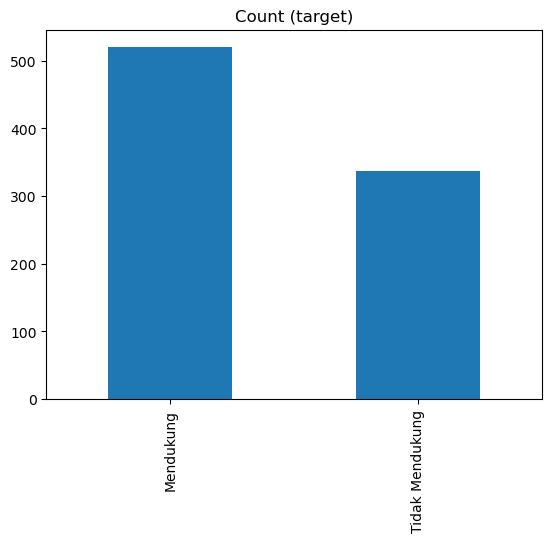

In [25]:
target_count = df_tweets['Label'].value_counts()
target_count.plot(kind='bar', title='Count (target)')
target_count

In [26]:
X = df_tweets['preprocess_tweet'].values
y = df_tweets['Label'].values

# 14. TF-IDF & Word Visualization
* TF-IDF adalah singkatan dari "Term Frequency – Inverse Document Frequency"
* CountVectorizer: Menghitung setiap jumlah kata/corpus yang muncul dalam kumpulan data tersebut
* Tfidf Transformer: Tranforming untuk perhitungan matriks dari CountVectorizer
* Word Visualization: Menampilkan kata dengan ukuran font berdasarkan pembobotan TF-IDF

In [27]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X)
tfidf_transformer = TfidfTransformer()
Train_X_Tfidf = tfidf_transformer.fit_transform(X_train_counts)

In [28]:
X_train_counts.shape

(857, 3020)

In [29]:
vectorizer = TfidfVectorizer(analyzer=lambda x: x, min_df=10)
token_vocab = df_tweets['tweet_norm2'].apply(word_tokenize_wrapper)
matrix = vectorizer.fit_transform([x for x in np.array(token_vocab)])
tfidf = dict(zip(vectorizer.get_feature_names_out(), vectorizer.idf_))
print ('vocab size :', len(tfidf))

vocab size : 120


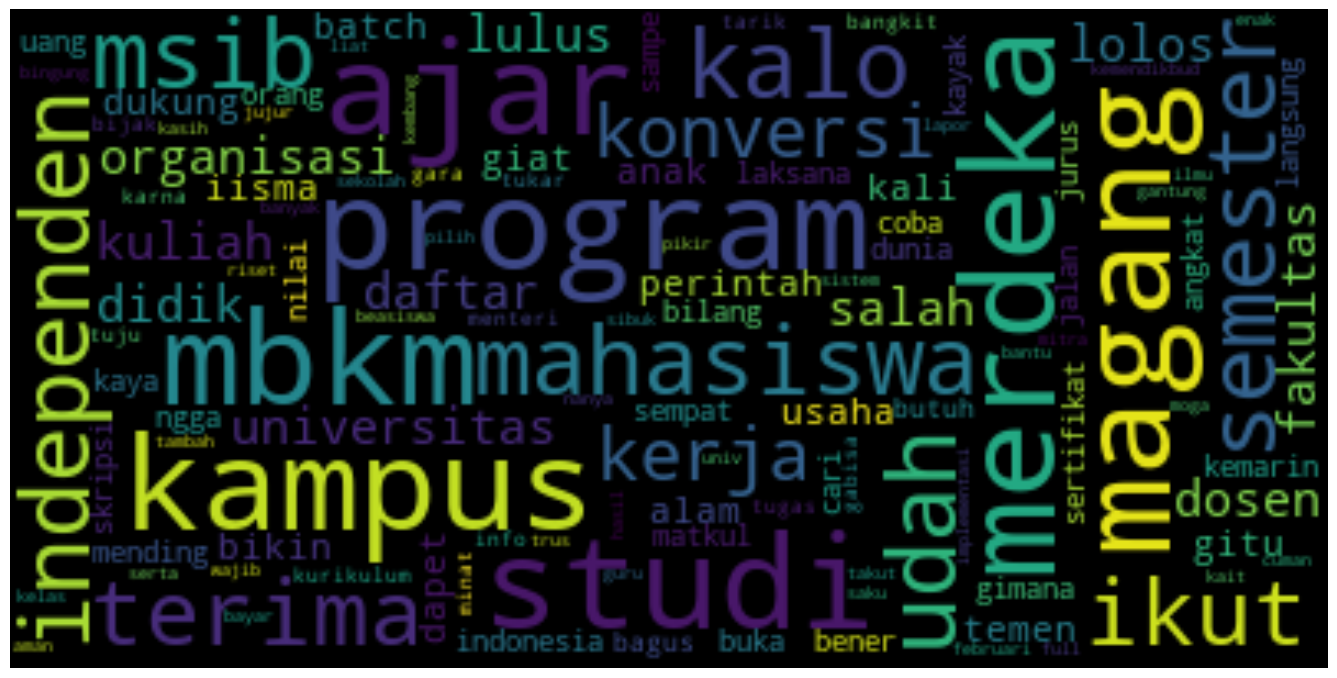

In [30]:
def plot_word_cloud(terms):
    text = terms.index
    text = ' '.join(list(text))
    # lower max_font_size
    wordcloud = WordCloud(max_font_size=40).generate(text)
    plt.figure(figsize=(17, 17))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

tfidf2 = pd.DataFrame(columns=['tfidf']).from_dict(dict(tfidf), orient='index')
tfidf2.columns = ['tfidf']    
plot_word_cloud(tfidf2.sort_values(by=['tfidf'], ascending=True))

# 15. Data splitting for 80% data training & 20% data testing 

### Menggunakan teknik sampling SMOTE (Synthetic Minority Over-sampling Technique) 

Namun, karena dataset memiliki masalah ketidakseimbangan kelas, maka dilakukan oversampling pada data training menggunakan metode SMOTE. Setelah itu, model dibuat dan dilatih pada data training yang telah di-oversampling, dan kemudian digunakan untuk melakukan prediksi pada data testing.

In [31]:
from imblearn.over_sampling import SMOTE
train_pct_index = int(0.8 * len(X))
X_train, X_test = Train_X_Tfidf[:train_pct_index], Train_X_Tfidf[train_pct_index:]
y_train, y_test = y[:train_pct_index], y[train_pct_index:]
X_train, X_test, y_train, y_test = train_test_split(Train_X_Tfidf, y, test_size=0.2)
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# 16. Create & fitting model Naive Bayes

In [32]:
start_time = datetime.now()
mnb = MultinomialNB()
mnb.fit(X_train_resampled, y_train_resampled)
y_pred2 = mnb.predict(X_test)
end_time = datetime.now()
print("Duration: {}".format(end_time - start_time))

Duration: 0:00:00.021458


# 17. Evaluation

Accuracy 79.65
                 precision    recall  f1-score   support

Tidak Mendukung       0.81      0.85      0.83       100
      Mendukung       0.78      0.72      0.75        72

       accuracy                           0.80       172
      macro avg       0.79      0.79      0.79       172
   weighted avg       0.80      0.80      0.80       172



Text(50.72222222222221, 0.5, 'Label sebenarnya')

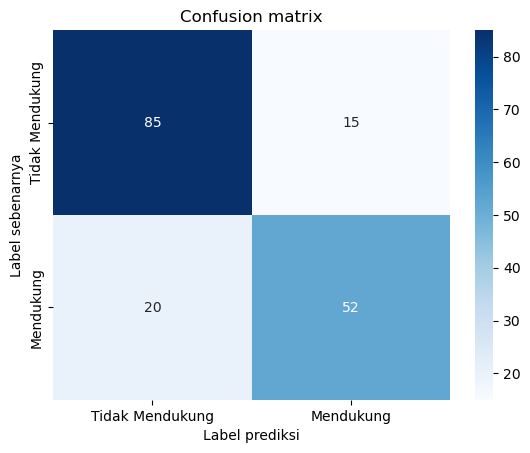

In [33]:
from sklearn.metrics import f1_score
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from pandas import DataFrame

# print(confusion_matrix(y_test,y_pred2))
# print(classification_report(y_test,y_pred2))
print("Accuracy %.2f" % (accuracy_score(y_pred2, y_test) * 100 ))
print(metrics.classification_report(y_test, y_pred2, target_names=['Tidak Mendukung', 'Mendukung']))

columns = ['Tidak Mendukung', 'Mendukung']
confm = confusion_matrix(y_test, y_pred2)
df_cm = DataFrame(confm, index=columns, columns=columns)

ax = sn.heatmap(df_cm, cmap='Blues', annot=True)
ax.set_title('Confusion matrix')
ax.set_xlabel('Label prediksi')
ax.set_ylabel('Label sebenarnya')

In [34]:
import pickle

# Muat model dari file
filename = 'model/model_naive_bayes.pkl'
with open(filename, 'wb') as file:
    pickle.dump(mnb, file)

In [35]:

# Muat model dari file
filename1 = 'model/count_vect.pkl'
with open(filename1, 'wb') as file:
    pickle.dump(count_vect, file)

In [36]:
# Muat model dari file
filename2 = 'model/tfidf_transformer.pkl'
with open(filename2, 'wb') as file:
    pickle.dump(tfidf_transformer, file)

# 18. Prediction

### Menggunakan smote


In [41]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import pandas as pd



stop_words = set(stopwords.words('indonesian'))
# stop_words.add('kampus')
# stop_words.add('merdeka')
# stop_words.add('magang')

test = input('Masukkan kalimat dalam bahasa Indonesia > ')
text = re.sub(r'[^\w\s]','', test)
text = text.encode('ascii', 'replace').decode('ascii')
text = ' '.join(re.sub("([@#][A-Za-z0-9]+)|(\w+:\/\/\S+)"," ", text).split())
text = text.lower()

words = word_tokenize(text)
filtered_words = [word for word in words if word.casefold() not in stop_words]
text = ' '.join(filtered_words)

my_list_test = [text]
predicted = []

for i in my_list_test:
    a = count_vect.transform([i])
    X_coba = tfidf_transformer.fit_transform(a).toarray()
    y_pred = mnb.predict(X_coba)
    acc = mnb.predict_proba(X_coba)
    probmnb = acc.max(axis=1)
    pd.options.display.float_format = '{:,.2f}%'.format
    predicted.append({"tweet": test, "stopwords": i, "tokens": filtered_words, "label" : y_pred[0], "probability" : probmnb[0]*100})

pd.DataFrame(predicted)


Masukkan kalimat dalam bahasa Indonesia > ikut magang merdeka seru banget


,tweet,stopwords,tokens,label,probability
0,ikut magang merdeka seru banget,magang merdeka seru banget,"[magang, merdeka, seru, banget]",Mendukung,82.49%
